# 1. Imports

In [1]:
from art.attacks.evasion import *
from art.estimators.classification import TensorFlowV2Classifier

import numpy as np
from math import pi
from random import random, randint

import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt

from tensorflow.keras.losses import MSE
from tensorflow.keras.losses import categorical_crossentropy as CCE
from tensorflow.keras.models import load_model

import os
import warnings
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [5]:
# Load ACAS properties from another python file
from properties import *

# 2. Load models

In [ ]:
path_model = "ACAS_XU_tf_keras/ACASXU_1_1.h5"

model_11 = load_model(path_model)

model_11.compile()

model_11.summary()

# 3. Home-made FGSM

In [ ]:
def generate_adv_sample(model, x0, label, loss_function="MSE", eps=1e-5):
    # transforming into a tensorflow object
    x0_ = tf.cast(x0, tf.float32)
    
    # record our gradients
    with tf.GradientTape() as tape:
        # explicitly indicate that our input should be tacked for gradient updates
        tape.watch(x0_)

        # use our model to make predictions on the input and then compute the loss
        pred = model(x0_)
        if loss_function == "CCE":
            np_label = np.array([i==label for i in range(0,5)]).reshape((1,5))
            loss = CCE(np_label, pred)
        elif loss_function == "MSE":
            loss = MSE(label, pred)
        else:
            raise Exception("Unknown loss function '{0}'".format(loss_function))
        
        # calculate the gradients of loss with respect to the input, then compute the sign of the gradient
        gradient = tape.gradient(loss, x0_)
        signedGrad = tf.sign(gradient)

        # construct the image adversary
        adv_sample = (x0_ + (signedGrad * eps)).numpy()

        # return the adversarial sample to the calling function
        return(adv_sample)

# 4. Generate points & check properties

In [ ]:
def random_pts(n, prop_dom, main_dom):
    """ prop_dom is a list of domains given by intervals in a numpy 2x5 table. """
    ndom = len(prop_dom)
    ndim = main_dom.shape[1]
    
    x = np.zeros((n,ndim))
    for i in range(n): # generate the i-th point
        choosen_dom = prop_dom[randint(0,ndom-1)] # choose the input property domain for a given prop
        for k in range(ndim): # create a random coord for each dim
            boundaries = main_dom[:,k]
            if choosen_dom[0,k] != None:
                boundaries[0] = choosen_dom[0,k]
            if choosen_dom[1,k] != None:
                boundaries[1] = choosen_dom[1,k]
            x[i,k] = boundaries[0] + random()*(boundaries[1]-boundaries[0])

    return(x)

In [ ]:
def random_main_pts(n, main_dom):
    """ Generate random points in the main domain given by intervals stored in a numpy 2x5 table. """
    ndim = main_dom.shape[1]
    
    x = np.zeros((n,ndim))
    for k in range(ndim): # create a random coord for each dim
        col = main_dom[0,k]*np.ones((n,1)) + np.random.rand(n,1)*(main_dom[1,k] - main_dom[0,k])
        for i in range(n):
            x[i,k] = col[i]

    return(x)

In [ ]:
x_test = random_main_pts(1000, X_dom)

In [ ]:
def normalize(x, x_mean, x_range):
    (n,k) = x.shape
    nx = np.zeros((n,k))
    for i in range(n):
        for j in range(k):
            nx[i,j] = (x[i,j]-x_mean[j])/x_range[j]
    return(nx)

In [ ]:
def check_pts(model, input_pts, IP, OP):
    n = input_pts.shape[0]
    IO_check = np.zeros((n,2)) # 1st column : input checked - 2nd column : output checked
    
    norm_input = normalize(input_pts, X_mean, X_range) # normalize pts
    
    pred_pts = model.predict(norm_input) # make predictions with the model (neural net)
    
    for k in range(n):
        IO_check[k,0] = IP(input_pts[k,:]) # check input (just in case)
        IO_check[k,1] = OP(pred_pts[k,:]) # check output

    return(IO_check, pred_pts)

In [ ]:
rand_inputs = random_pts(1000000, IP2_dom, X_dom)

In [ ]:
Pcheck, pred_pts = check_pts(model_11, rand_inputs, IP1, OP1)

In [ ]:
def find_adverse(input_pts, prop_check):
    n = prop_check.shape[0]
    index = []
    for k in range(n):
        if prop_check[k,0] and not(prop_check[k,1]):
            index.append(k)
    return(input_pts[index,:])

In [ ]:
adv = find_adverse(rand_inputs, Pcheck)
print(adv.shape)

In [ ]:
Pcheck.shape

# 5. Attack the networks : FGSM & CW

In [34]:
ACAS_model = load_model("ACAS_XU_tf_keras/ACASXU_2_4.h5")

> See ConfusionMatrix_PIERRE.ipynb for the attacks + confusion matrix

### Save points in a file .npy

In [30]:
np.save("clear_pts.npy",original_pts)

In [31]:
test_data = np.load("clear_pts.npy")

# 6. Test des categories manquantes

In [2]:
def full_nets_id():
    """ Get the id of the 45 neural networks. """
    nets_id = []
    for k in range(11,60):
        if k%10 != 0:
            nets_id.append( (str(k//10),str(k%10)) )
    return(nets_id)

In [3]:
def get_label_frequency(npts, nets_id=None, show=False):
    """ Create 'npts' random points in the domain and make a prediction on each one of them
        with every nnet whose id is in 'nets_id'. """
    
    if nets_id == None: # all 45 networks
        nets_id = full_nets_id()
    else:
        for k in range(0,len(nets_id)):
            (na,nb) = nets_id[k]
            nets_id[k] = (str(na),str(nb))
    nnets = len(nets_id)
    
    base_pts = np.random.rand(npts, 5)
    all_freq = np.zeros((nnets,5))
    
    for k in range(0,nnets):
        
        # load the corresponding model
        (a,b) = nets_id[k]
        ACAS_model = load_model("ACAS_XU_tf_keras/ACASXU_{0}_{1}.h5".format(a,b), compile=False) # run-mode model only
        
        # make predictions and compute label frequencies
        base_pred = ACAS_model.predict(base_pts)                                                                              
        all_freq[k,:] = np.bincount(np.concatenate((np.argmin(base_pred, axis=1),np.arange(0,5)))) - np.ones(5)
        
        if show:
            print('ACAS-XU {0}-{1} : {2}'.format(a,b,all_freq[k,:]))
        
    return(all_freq.astype(int))

In [4]:
freq = get_label_frequency(10000, show=True)

ACAS-XU 1-1 : [9.127e+03 3.000e+00 2.770e+02 2.790e+02 3.140e+02]
ACAS-XU 1-2 : [8945.  114.  419.   68.  454.]
ACAS-XU 1-3 : [9.228e+03 4.000e+00 4.040e+02 1.880e+02 1.760e+02]
ACAS-XU 1-4 : [9339.   49.   24.  292.  296.]
ACAS-XU 1-5 : [8.964e+03 6.000e+00 1.500e+01 9.190e+02 9.600e+01]
ACAS-XU 1-6 : [9658.   54.  160.   71.   57.]
ACAS-XU 1-7 : [9.732e+03 0.000e+00 3.000e+00 4.000e+00 2.610e+02]
ACAS-XU 1-8 : [9.708e+03 4.700e+01 1.000e+00 2.440e+02 0.000e+00]
ACAS-XU 1-9 : [10000.     0.     0.     0.     0.]
ACAS-XU 2-1 : [6.752e+03 2.478e+03 0.000e+00 7.670e+02 3.000e+00]
ACAS-XU 2-2 : [8.206e+03 4.570e+02 1.000e+00 1.252e+03 8.400e+01]
ACAS-XU 2-3 : [7673. 1363.    0.  946.   18.]
ACAS-XU 2-4 : [7103. 1421.    0. 1467.    9.]
ACAS-XU 2-5 : [9030.  799.    0.  171.    0.]
ACAS-XU 2-6 : [8818. 1164.    0.   18.    0.]
ACAS-XU 2-7 : [9.41e+03 5.22e+02 1.60e+01 5.10e+01 1.00e+00]
ACAS-XU 2-8 : [9086.  914.    0.    0.    0.]
ACAS-XU 2-9 : [8.895e+03 1.097e+03 0.000e+00 8.000e+00 0.0

In [5]:
print(freq[:9,:])

[[ 9127     3   277   279   314]
 [ 8945   114   419    68   454]
 [ 9228     4   404   188   176]
 [ 9339    49    24   292   296]
 [ 8964     6    15   919    96]
 [ 9658    54   160    71    57]
 [ 9732     0     3     4   261]
 [ 9708    47     1   244     0]
 [10000     0     0     0     0]]


## Histplots and plots

In [6]:
ACAS_labels = ["COC","WR","WL","SR","SL"]

In [7]:
multiplot_pos = [(0,0),(0,1),(0,2),(1,1),(1,2)]
labels_color = [(0.5529411764705883, 0.6274509803921569, 0.796078431372549),
                (0.4, 0.7607843137254902, 0.6470588235294118),
                (0.6509803921568628, 0.8470588235294118, 0.32941176470588235),
                (0.8980392156862745, 0.7686274509803922, 0.5803921568627451),
                (0.9882352941176471, 0.5529411764705883, 0.3843137254901961)]
sns.color_palette("Set2")

[(0.4, 0.7607843137254902, 0.6470588235294118),
 (0.9882352941176471, 0.5529411764705883, 0.3843137254901961),
 (0.5529411764705883, 0.6274509803921569, 0.796078431372549),
 (0.9058823529411765, 0.5411764705882353, 0.7647058823529411),
 (0.6509803921568628, 0.8470588235294118, 0.32941176470588235),
 (1.0, 0.8509803921568627, 0.1843137254901961),
 (0.8980392156862745, 0.7686274509803922, 0.5803921568627451),
 (0.7019607843137254, 0.7019607843137254, 0.7019607843137254)]

In [8]:
df_freq = pd.DataFrame(freq, columns = ACAS_labels)
df_freq.head()

,COC,WR,WL,SR,SL
0,9127,3,277,279,314
1,8945,114,419,68,454
2,9228,4,404,188,176
3,9339,49,24,292,296
4,8964,6,15,919,96


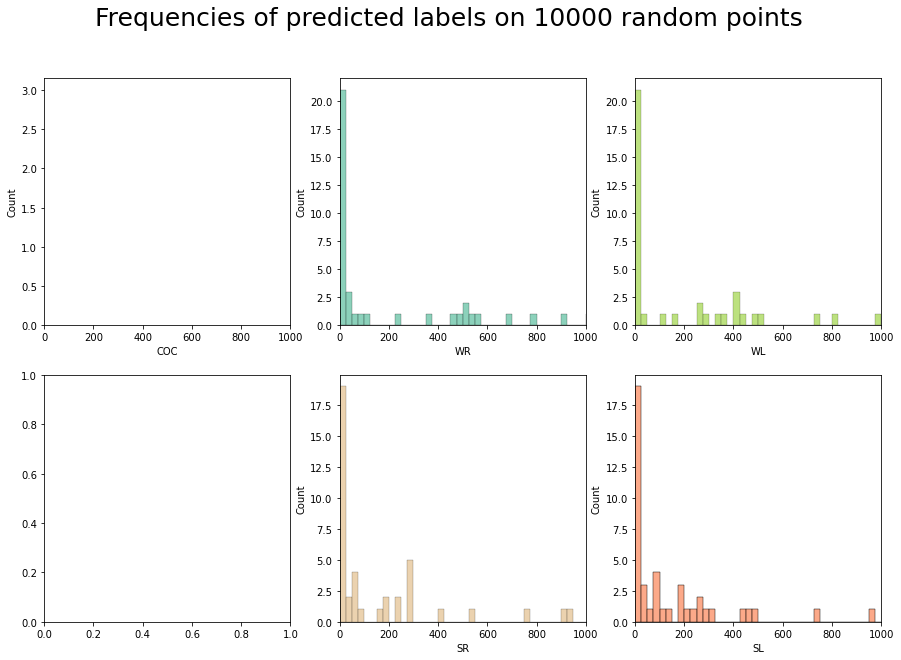

In [15]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10)) #, sharey=True)
fig.suptitle("Frequencies of predicted labels on {0} random points".format(np.sum(freq[0,:])), size=25)

bar_width = 25

for k in range(5):
    sns.histplot(ax=axes[multiplot_pos[k]], data = df_freq[ACAS_labels[k]], binwidth = bar_width, color = labels_color[k])
    axes[multiplot_pos[k]].set_xlim(0,1000)

plt.show()

In [10]:
sorted_index = np.argsort(freq, axis=0)

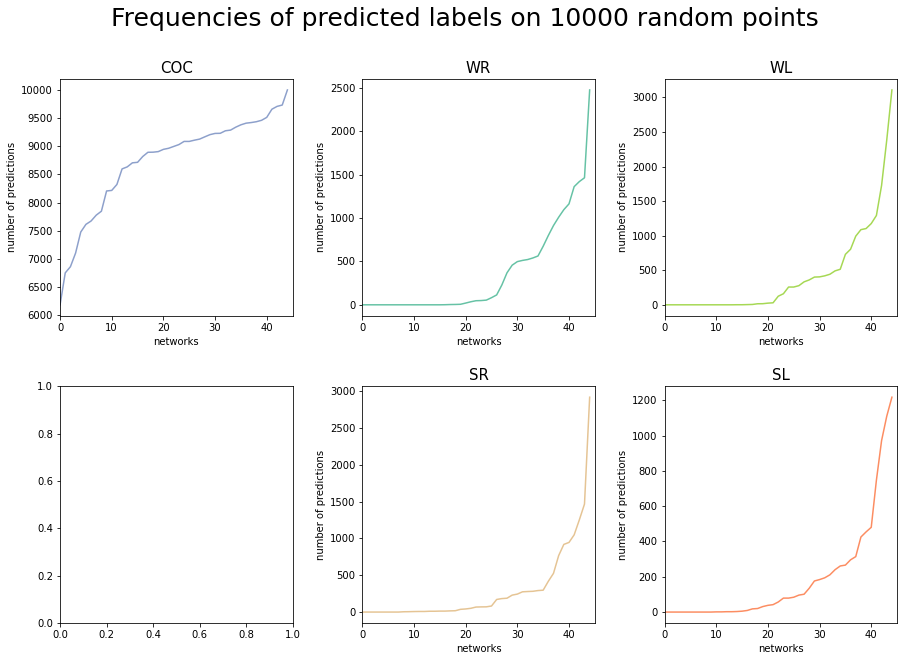

In [26]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10)) #, sharey=True)
plt.subplots_adjust(wspace = 0.3, hspace = 0.3)
fig.suptitle("Frequencies of predicted labels on {0} random points".format(np.sum(freq[0,:])), size=25)

for k in range(5):
    axes[multiplot_pos[k]].plot(freq[:,k][sorted_index[:,k]], color = labels_color[k])
    axes[multiplot_pos[k]].set_xlim(0,45)
    axes[multiplot_pos[k]].set_title(ACAS_labels[k], size=15)
    axes[multiplot_pos[k]].set_xlabel("networks") ; axes[multiplot_pos[k]].set_ylabel("number of predictions")
    
plt.show()